In [3]:
import sys
sys.path.append("../")

<center> This notebook allows us to present our results to real life application </center> 

In [6]:
import numpy as np
import matplotlib.pyplot as plt 
from tqdm import tqdm 
from typing import Callable

from SDE.utils.matrix import Matrix
import SDE.utils.yfinance_functions as yf
from SDE.pricer import PricingConfiguration, Option

from SDE.basket import Weighted_Basket, Basket,AssetND,BS_Basket
from SDE.bs import BS_Asset

# <center> Build portfolio using real parameters </center> 

In [7]:
my_portfolio_tickers = ['AAPL', 'AMZN', 'TSLA']     # yahoo finance tickers of assets we want
my_exposures = np.array([1/3,1/3,1/3])              # weights corresponding to exposure on each asset's PERFORMANCE (=> to be divided by stocks)

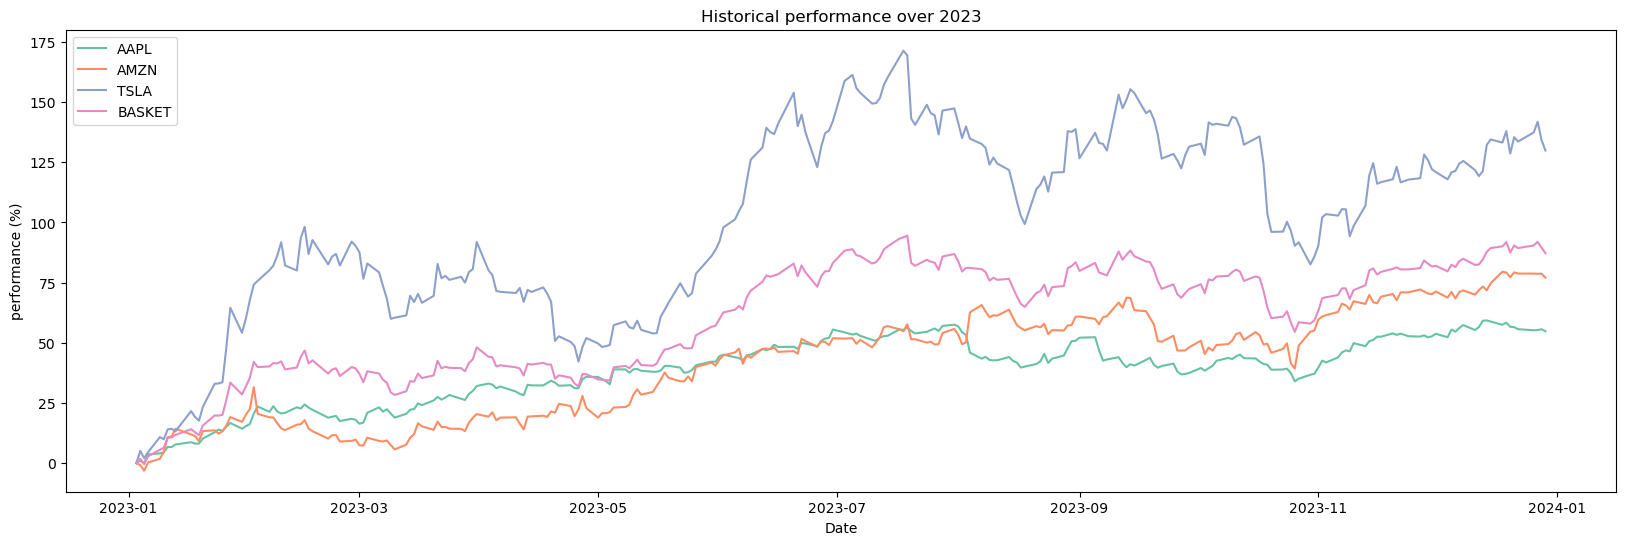

******* TODAY VALUES *******
                                 AAPL   AMZN        TSLA
Date                                                    
2024-05-01 00:00:00-04:00  169.300003  179.0  179.990005
******* 2023 ANNUAL VOL *******
AAPL    0.199543
AMZN    0.330267
TSLA    0.526488
dtype: float64
***** 2023 ANNUAL CORREL ******
          AAPL      AMZN      TSLA
AAPL  1.000000  0.884748  0.827503
AMZN  0.884748  1.000000  0.793269
TSLA  0.827503  0.793269  1.000000
*** REAL WEIGHTS TO GET TARGETED EXPOSURE ****
                               AAPL     AMZN      TSLA
Date                                                  
2024-05-01 00:00:00-04:00  0.196889  0.18622  0.185195


In [8]:
ticker_symbols = my_portfolio_tickers       # List of ticker symbols
start_date = '2023-01-01'                   # Start date
end_date = '2024-01-01'                     # End date
today_date = '2024-05-01'                   # Date at which we set the values

historical_data = yf.get_historical_data(ticker_symbols, start_date, end_date)
today_data = yf.get_date_data(ticker_symbols, today_date)

##### COMPUTE ANNUAL PERFORMANCE ####
historical_perf_start_of_year = (historical_data/historical_data.iloc[0]-1)*100
historical_perf_start_of_year["BASKET"] = np.dot(historical_perf_start_of_year,my_exposures)

##### ANNUAL TRACK #####
yf.plot_stock_curves(historical_perf_start_of_year,"Historical performance over 2023",ylabel="performance (%)")

##### TODAY SPOT #####
print("******* TODAY VALUES *******")
print(today_data)

##### ANNUAL VOL #####
print("******* 2023 ANNUAL VOL *******")
print(yf.compute_annual_volatility(historical_data))

### ANNUAL CORREL ###
print("***** 2023 ANNUAL CORREL ******")
print(yf.compute_correlation_matrix(historical_data))

### WEIGHTS TARGETED ###
print("*** REAL WEIGHTS TO GET TARGETED EXPOSURE ****")
print(100*my_exposures/today_data)

# <center> Build basket </center> 

<center> 
In this section, we build the basket corresponding to an equi-weighted basket between the three assets found above  </br>
The basket is made such that we are exposed equally on the performance on each asset adn initial spot of basket = 200.
</center> 

In [9]:
risk_free_rate = 0.05

# taking real life parameters found above
asset_AAPL = BS_Asset(169.300003,0.20,risk_free_rate,scheme="euler") # schme can be set to milstein
asset_AMZN = BS_Asset(179,0.32,risk_free_rate)
asset_TSLA = BS_Asset(179.99,0.53,risk_free_rate)
correl_matrix = [[1.000000, 0.884748, 0.827503], [0.884748, 1.000000, 0.793269], [0.827503, 0.793269, 1.000000]]

adjusted_weights = [2*0.196889,2*0.18622,2*0.185195]
my_basket_object = Weighted_Basket(adjusted_weights,[asset_AAPL,asset_AMZN,asset_TSLA],Matrix(correl_matrix),live_seed=True) # better to set live to true to significatively to not introduce bad seed biais

print(f"Inital spot of my basket: {round(my_basket_object.initial_spot,2)}")

Inital spot of my basket: 200.0


# <center> Pricing (single asset)</center> 
</br>
<center>
This is an introductive session to what can be done in pricing.
</br>
To see more content about variance reduction techniques please take a look at <b>mcls_variance_reduction_results.ipynb</b> and <b>variance_reduction_results.ipynb</b>

<center>

In [6]:
# ATM Option for AAPL
call_option_object = Option(
            strike = 169,
            #terminal_payoff_function=lambda x: max(x-200,0), # not required for call or put but can be set to whatever
            actualisation_rate= 0.05,
            maturity= 1,
            payoff_name= "call"     # allows not to give payoff but not mandatory
            )

### EXEMPLE OF PRICING USING CLOSED FORM FORMULA ###
# pricing_model_name = "CF" is set by default when not providing pricing config
#

print(f"CF European price is: {call_option_object.Price(asset_AAPL,display_info=True)} \n")


### EXEMPLE OF PRICING USING PRE DEFINED REDUCTION TECHNIQUE FOR MC ###
#
#

pricing_config = PricingConfiguration(nb_simulations=1000000,pricing_model_name="MC")             # build pricing config
call_option_object.set_pricing_configuration(pricing_config)                                    # set pricing config to option object
print(f"MC European price is: {call_option_object.Price(asset_AAPL,display_info=True)} \n")     # price with according underlying


### EXEMPLE OF PRICING FOR MCLS ###
#
#

pricing_config = PricingConfiguration(nb_simulations=1000000,pricing_model_name="MCLS")     # set MCLS model here
call_option_object.set_pricing_configuration(pricing_config)
print(f"MCLS European price is: {call_option_object.Price(asset_AAPL,display_info=True)} \n")



### EXEMPLE OF PRICING USING PRE DEFINED REDUCTION TECHNIQUE FOR MC ###
#
#

pricing_config = PricingConfiguration(nb_simulations=1000000,pricing_model_name="MC")
call_option_object.set_pricing_configuration(pricing_config)
call_option_object.set_predefined_pricing_reduction_techniques(asset_AAPL)                      # load antithetic variance technique
call_option_object.set_pricing_antithetic()                                                     # activate antithetic pricing
print(f"MC European price is: {call_option_object.Price(asset_AAPL,display_info=True)} \n")



            =========================== RESULTS ==========================
                            result : 17.853036118306377
                       option name : call
                     exercise type : european
                     pricing model : CF
             number of simulations : 1000 (Not Applicable)
                        antithetic : None (Not Applicable)
                   control variate : None (Not Applicable)
                      quasi random : False (Not Applicable)
            
CF European price is: 17.853036118306377 


            =========================== RESULTS ==========================
                            result : 17.858621267925546
                       option name : call
                     exercise type : european
                     pricing model : MC
             number of simulations : 1000000 (Applicable)
                        antithetic : None (Applicable)
                   control variate : None (Applicable)
                   

# <center> Pricing (Basket)</center> 
</br>
<center>
This is an introductive session to what can be done in pricing.
</br>
To see more content about variance reduction techniques please take a look at <b>mcls_variance_reduction_results.ipynb</b> and <b>variance_reduction_results.ipynb</b>

<center>

In [7]:
# ATM Option for basket
call_option_object = Option(
            strike = 200,
            #terminal_payoff_function=lambda x: max(x-200,0), # not required for call or put but can be set to whatever
            actualisation_rate= 0.05,
            exercise_times= [0,1/5,2/5,3/5,4/5,1],
            exercise_type= "bermudean",
            payoff_name= "call"     # allows not to give payoff but not mandatory
            )

### EXEMPLE OF PRICING USING CLOSED FORM FORMULA ###
# pricing_model_name = "CF" is set by default when not providing pricing config
# -> error will be raised as you cannot price in closed form for bermudean options

#print(f"CF European price is: {call_option_object.Price(my_basket_object,display_info=True)} \n")


### EXEMPLE OF PRICING USING PRE DEFINED REDUCTION TECHNIQUE FOR MC ###
#   -> error will be raised as you cannot price in MC for bermudean options
#


### EXEMPLE OF PRICING FOR MCLS ###
#
#

pricing_config = PricingConfiguration(nb_simulations=10000,pricing_model_name="MCLS")     # set MCLS model here
call_option_object.set_pricing_configuration(pricing_config)
print(f"MCLS Bermudean price is: {call_option_object.Price(my_basket_object,display_info=True)} \n")


### EXEMPLE OF PRICING USING PRE DEFINED REDUCTION TECHNIQUE FOR MCLS ###
#
#

pricing_config = PricingConfiguration(nb_simulations=10000,pricing_model_name="MCLS")
call_option_object.set_pricing_configuration(pricing_config)
call_option_object.set_predefined_pricing_reduction_techniques(my_basket_object)                    # **load existing variance techniques** here :  antithetic 
call_option_object.set_pricing_antithetic()                                                         # activate antithetic pricing
call_option_object.set_pricing_control_variate()                                                    # activate control variate pricing
print(f"MCLS Bermudean price is: {call_option_object.Price(my_basket_object,display_info=True)} \n")



            =========================== RESULTS ==========================
                            result : 30.529413107093447
                       option name : call
                     exercise type : bermudean
                     pricing model : MCLS
             number of simulations : 10000 (Applicable)
                        antithetic : None (Applicable)
                   control variate : None (Applicable)
                      quasi random : False (Applicable)
            
MCLS Bermudean price is: 30.529413107093447 

  Antithetic var. set for pricing  bermudean call on <class 'SDE.basket.Weighted_Basket'> 
  Control var. set for pricing  bermudean call on <class 'SDE.basket.Weighted_Basket'> 

            =========================== RESULTS ==========================
                            result : 30.62395411328797
                       option name : call
                     exercise type : bermudean
                     pricing model : MCLS
             nu

# <center> Pricing other Basket Options -> case of BO options</center> 
## <center> Setting manually variance reduction technic</center> 
</br>
<center>
Pricing can easily be extended to other basket type. We can either define a new object as a Basket subclass or build a new one as done below
<center>

In [10]:
from scipy.stats import norm

# 0/ define underlying
base_undl_price = 200      # meaning we want our underlying to be at this value at t0
adjusted_weights_BO = [base_undl_price/169,base_undl_price/179,base_undl_price/180]

my_BO_basket = BS_Basket(adjusted_weights_BO,[asset_AAPL,asset_AMZN,asset_TSLA],correl_matrix=Matrix(correl_matrix),live_seed=True,aggregate_function=np.max) # setting function max as aggregate
print(f"Value at 0 of Best of Basket is {my_BO_basket.initial_spot}")

# 1/ define option
maturity = 1
call_option_object = Option(
            strike = base_undl_price,          # ATM OPTION
            #terminal_payoff_function=lambda x: max(x-200,0), # not required for call or put but can be set to whatever
            actualisation_rate= 0.05,
            maturity= maturity,
            exercise_type= "european",
            payoff_name= "call"                # allows not to give payoff but not mandatory
            )

# 2/ define pricing config
pricing_config = PricingConfiguration(pricing_model_name="MC",      # pricing in monte carlo
                                      nb_simulations= 100000,
                                      is_antithetic= True,          # pricing with antithetic
                                      #is_control_variate= True      # pricing with control
                                      )
# AND SET TO OPTION 
call_option_object.set_pricing_configuration(pricing_config)

# 3/ give mannually variance reducition techniques 
A = lambda x: -x

## CHECKING CORRECTNESS OF FUNCTION H0 OF CONTROL VARIATE FOR BEST OF OPTIONS
def m_function(undl:Basket,r,T,K):
    d = undl.dimension
    alpha = np.power(np.product([alpha_i*a.initial_spot for alpha_i,a in zip(undl.weights,undl.assetND.assets)]),1/d)
    alpha *= np.exp(T/d*np.sum([a.rf - a.vol**2/2 for a in undl.assetND.assets]))
    
    vol_vec = np.array([a.vol*np.sqrt(T)/d for a in undl.assetND.assets])
    vol = np.sqrt(np.dot(np.dot(vol_vec.T,undl.assetND.correl_matrix.m),vol_vec))
    d1 = np.log(alpha/K)/vol - vol
    d2 = d1 - vol

    return np.exp(-r*T)*alpha*np.exp(0.5*vol**2)*norm.cdf(d1) - K*norm.cdf(d2)

# m = # add here m_function giving E[h0(X)]

# h0_function = lambda brownians : call_option_object._actualised_payoff_function(my_BO_basket.prod_simulate_with_brownian(maturity,brownians))

call_option_object.set_pricing_reduction_techniques(A=A) #,h0_function=h0_function,m_value=m)


# 4/ activate reduction methods
call_option_object.set_pricing_antithetic()         # here already set to true when building config
#call_option_object.set_pricing_control_variate()    # here already set to true when building config

# 5/ price
print(f"MC european price for ATM Best of option is: {call_option_object.Price(my_BO_basket,display_info=True)} \n")

Value at 0 of Best of Basket is 200.35503313609468

            =========================== RESULTS ==========================
                            result : 52.13950988299669
                       option name : call
                     exercise type : european
                     pricing model : MC
             number of simulations : 100000 (Applicable)
                        antithetic : True (Applicable)
                   control variate : None (Applicable)
                      quasi random : False (Applicable)
            
MCLS european price for ATM Best of option is: 52.13950988299669 

